In [1]:
import tdb
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
data = tdb.load_tdb("../test_files/databases/hprc_105.tdb/",
                    lfilters=[("chrom", "=", "chr4")]) # subsetting to run faster

In [3]:
metadata = (pd.read_csv("../test_files/igsr_samples.tsv", sep='\t')
                .where(lambda x: x["Sample name"].isin(data["sample"].keys()))
                .dropna()
                .set_index(["Sample name"]))


In [4]:
allele_lengths = data["allele"].set_index(["LocusID", "allele_number"])["allele_length"]

In [5]:
rows = []
pops = []
for samp, table in data["sample"].items():
    if samp not in metadata.index:
        continue
    pops.extend([metadata.loc[samp]["Superpopulation code"]])# * 2)
    view = table.set_index(["LocusID", "allele_number"])
    view["allele_length"] = allele_lengths
    # 1::2 - get column separation - because of hets...? or non-ref I should say.. but lose ::2's almost perfect 
    # row separation
    # I think I should be taking the more common allele.
    rows.append(view.iloc[::2]["allele_length"].reset_index(level=1, drop=True))
    #just take the first allele - or every other, whatever
    #rows.append(view.iloc[1::2]["allele_length"].reset_index(level=1, drop=True))

In [6]:
# Subset to Loci with >= 10 alleles
loci_ac = data["allele"]["LocusID"].value_counts().where(lambda x: x >= 20).dropna()

In [7]:
heatmap = np.empty((len(rows), len(loci_ac)))
heatmap[:] = np.nan
heatmap.shape

(94, 8224)

In [8]:
allen_idx_lookup = dict(zip(loci_ac.index, range(len(loci_ac))))

In [9]:
for samp_idx, r in enumerate(rows):
    for locus, observed_len in r.items():
        if locus not in allen_idx_lookup: continue
        heatmap[samp_idx, allen_idx_lookup[locus]] = observed_len

In [10]:
#keep = heatmap.ptp(0) >= 20

In [11]:
sub_heat = heatmap#[:, keep] # only keep the most variable by length sites

In [12]:
center = np.nanmean(sub_heat, axis=0)
shifted_hm = (sub_heat - center) / sub_heat.ptp(0)
shifted_hm = shifted_hm[:, sub_heat.mean(axis=0).argsort()] # sort by loci's average length
# remove unobserved loci, I guess?
# m_mins = m_mins[~np.isnan(m_mins)]

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_15103/3179241762.py:2: RuntimeWarning: invalid value encountered in divide
  shifted_hm = (sub_heat - center) / sub_heat.ptp(0)


In [13]:
set(pops)

{'AFR', 'AMR', 'EAS', 'SAS'}

In [14]:
lut = dict(zip(set(pops), ['darksalmon', 'palegreen', 'deepskyblue', 'violet']))
row_colors = [lut[_] for _ in pops]

In [15]:
row_colors_allele = 'rb' * (len(pops) // 2) #['darksalmon', 'palegreen', 'deepskyblue', 'violet']))
#row_colors = [lut[_] for _ in pops]

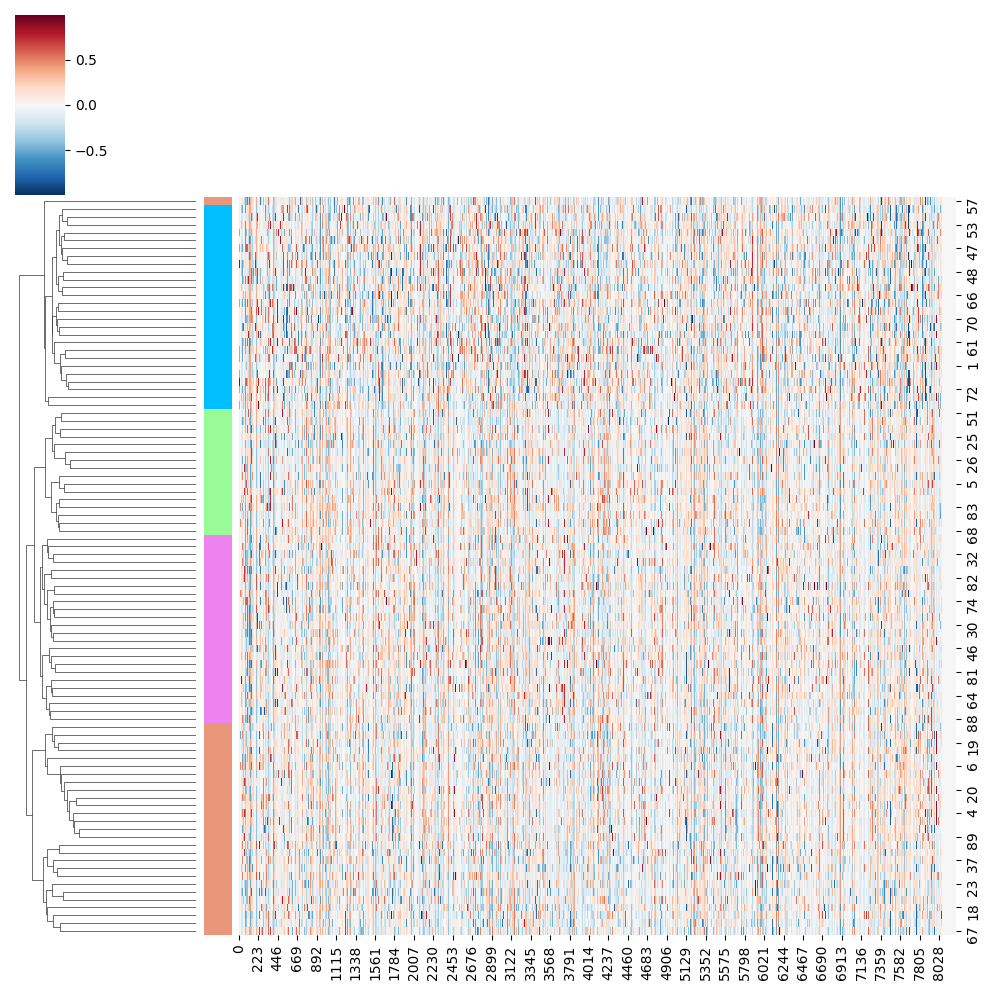

In [16]:
sb.clustermap(np.nan_to_num(shifted_hm), 
              col_cluster=False, 
              row_colors=row_colors, 
              method="complete",
              metric="correlation", # cityblock, braycurtis - i liked how this looked
              cmap=cm.RdBu_r)

How the alleles are reported isn't random. There's some pattern (presumably the shorter is first).

I don't have long-range phasing to actually consider the alleles separately.

Or I can try to figure out an allele length average?

Or I can only do the longer/shorter of the two alleles?

Or I can only take homozygous sites...?

I like the last idea the best. (reuse transform?)

Whatever...
So we can find population structure. Let's do it again, but I want AF in the cells.

In [17]:
allele_freq = tdb.allele_count_length(data)

In [18]:
allele_freq = allele_freq[allele_freq["AF"] >= 0.02]

In [19]:
al = (allele_lengths.reset_index()
          .sort_values(["LocusID", "allele_number", "allele_length"])
          .drop_duplicates(["LocusID", "allele_length"])
          .set_index(["LocusID", "allele_length"]))
af = allele_freq.reset_index().set_index(["LocusID", "allele_length"])

In [20]:
af['allele_number'] = al
af = af.reset_index().set_index(["LocusID", "allele_number"])["AF"]

In [21]:
rows = []
pops = []
for samp, table in data["sample"].items():
    if samp not in metadata.index:
        continue
    pops.extend([metadata.loc[samp]["Superpopulation code"]])# * 2)
    view = table.set_index(["LocusID", "allele_number"])
    view["allele_freq"] = af
    view = view[~view["allele_freq"].isna()]
    # I think I should be taking the more common allele.
    rows.append(view["allele_freq"].reset_index().groupby(["LocusID"])["allele_freq"].max())
    #just take the first allele - or every other, whatever
    #rows.append(view.iloc[1::2]["allele_length"].reset_index(level=1, drop=True))

In [38]:
loci_ac = af.reset_index()["LocusID"].value_counts().where(lambda x: (x >= 5)).dropna()
heatmap2 = np.empty((len(rows), len(loci_ac)))
heatmap2[:] = np.nan

allen_idx_lookup = dict(zip(loci_ac.index, range(len(loci_ac))))
for samp_idx, r in enumerate(rows):
    for locus, observed_len_af in r.items():
        if locus not in allen_idx_lookup: continue
        heatmap2[samp_idx, allen_idx_lookup[locus]] = observed_len_af

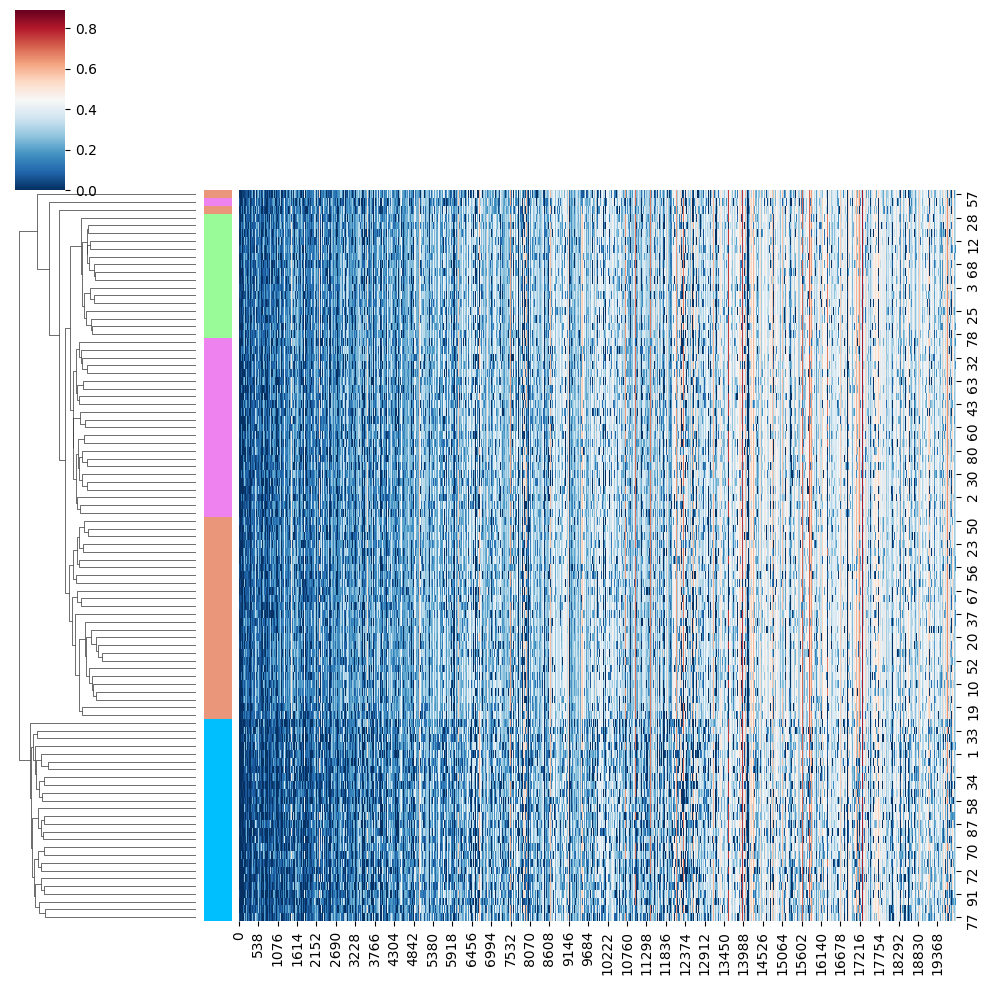

In [39]:
p = sb.clustermap(np.nan_to_num(heatmap2), 
                  col_cluster=False, 
                  row_colors=row_colors, 
                  method="complete",
                  metric="correlation", # cityblock, braycurtis - i liked how this looked
                  cmap=cm.RdBu_r)
p.ax_col_dendrogram.set_visible(False)

In [24]:
#import sys
#sys.setrecursionlimit(100000)